In [2]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx4m\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx3m\\" # this
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\test_oscillations\\"
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\sm_output"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

# Name of file to run (must be located in target_dir)
target_file = "conduit_p.py"

In [3]:
%load_ext autoreload
%autoreload 2

# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys
import scipy

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

In [4]:
# Load sm_output/*gp_sig
num_doms = 10
def solver1D_from(i):
  solvers = []
  for dom_idx in range(num_doms):
    filename = f"conduit_sub{dom_idx}_{i}00.pkl"
    if i == 0:
      filename = f"conduit_sub{dom_idx}_0.pkl"
    solvers.append(readwritedatafiles.read_data_file(filename))
  return solvers

# 0, 16, 32, 48, 64, 80
solvers = solver1D_from(16)


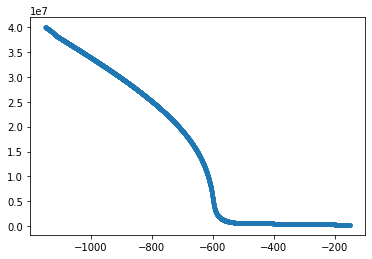

In [5]:
def collate(quantity:str, solvers):
  if quantity == "yF":
    quants = np.concatenate([solver.state_coeffs[...,7:8] / solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
              for solver in solvers], axis=0)
  else:
    quants = np.concatenate([solvers[0].physics.compute_variable(quantity, solver.state_coeffs)
              for solver in solvers], axis=0)
  x = np.concatenate([solver.elem_helpers.x_elems
            for solver in solvers], axis=0)
  return x, quants
x_nodes, p = collate("Pressure", solvers)
# x_nodes = solver.elem_helpers.x_elems
plt.plot(x_nodes.ravel(), p.ravel(), '.-')

p_t = []
rho_t = []
u_t = []
M_t = []
yWv_t = []
yWt_t = []
yC_t = []
yF_t = []
t_range = []
for time_idx in range(1,280,2):
  solvr = solver1D_from(time_idx)
  x_nodes, p = collate("Pressure", solvr)
  _, u = collate("XVelocity", solvr)
  _, c = collate("SoundSpeed", solvr)

  _, arhoA = collate("pDensityA", solvr)
  _, arhoWv = collate("pDensityWv", solvr)
  _, arhoWt = collate("pDensityWt", solvr)
  _, arhoM = collate("pDensityM", solvr)
  _, yF = collate("yF", solvr)
  rho = arhoA + arhoWv + arhoM

  _, yC = collate("pDensityC", solvr) / rho
  p_t.append(p)
  rho_t.append(rho)
  u_t.append(u)
  M_t.append(u/c)
  yC_t.append(yC)
  yF_t.append(yF)
  t_range.append(solver1D_from(time_idx)[0].time)
  yWv_t.append(arhoWv / rho)
  yWt_t.append(arhoWt / rho)

p_t = np.array(p_t)
rho_t = np.array(rho_t)
u_t = np.array(u_t)
M_t = np.array(M_t)
yC_t = np.array(yC_t)
yF_t = np.array(yF_t)
t_range = np.array(t_range)
yWv_t = np.array(yWv_t)
yWt_t = np.array(yWt_t)


In [6]:
# Contour plot prep
compressible_mg_p = np.reshape(p_t, (p_t.shape[0], -1,))
compressible_mg_u = np.reshape(u_t, (u_t.shape[0], -1,))
compressible_mg_x, compressible_mg_t = np.meshgrid(x_nodes.ravel(), t_range)
mg_from_array = lambda array: np.reshape(array, (array.shape[0], -1,))

compressible_mg_rho = mg_from_array(rho_t)
compressible_mg_u = mg_from_array(u_t)
compressible_mg_M = mg_from_array(M_t)
compressible_mg_yC = mg_from_array(yC_t)
compressible_mg_yF = mg_from_array(yF_t)
compressible_mg_yWv = mg_from_array(yWv_t)
compressible_mg_yWt = mg_from_array(yWt_t)

compressible_mg_p.shape, compressible_mg_x.shape, compressible_mg_t.shape

((140, 6000), (140, 6000), (140, 6000))

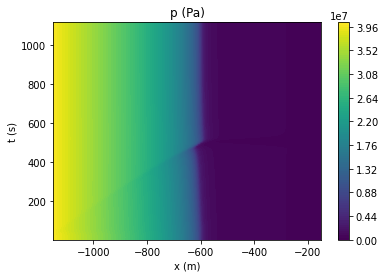

In [7]:
# Contour plot
# p_t.shape, x_nodes.shape, t_range.shape

plt.contourf(compressible_mg_x, compressible_mg_t, compressible_mg_p, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("p (Pa)")
plt.colorbar()

In [10]:
out_xvf = {
  "q_pu": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_0_q_pu.npy"),
  "q_t": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_0_q_t.npy"),
  "x": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_0_x.npy"),
  "t": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_0_t.npy"),
}
out_xvf["mg_x"], out_xvf["mg_t"] = np.meshgrid(out_xvf["x"], out_xvf["t"])

out_xvf_tau2 = {
  "q2": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run2_q2.npy"),
  "q5": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run2_q5.npy"),
  "x": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run2_x.npy"),
  "t": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run2_t.npy"),
}

out_xvf_tau3 = {
  "q2": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run3_q2.npy"),
  "q5": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run3_q5.npy"),
  "x": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run3_x.npy"),
  "t": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run3_t.npy"),
}

out_xvf_tau4 = {
  "q2": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run6_q2.npy"),
  "q5": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run6_q5.npy"),
  "x": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run6_x.npy"),
  "t": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run6_t.npy"),
}

out_xvf_tau11 = {
  "q2": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run11_q2.npy"),
  "q5": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run11_q5.npy"),
  "x": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run11_x.npy"),
  "t": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run11_t.npy"),
}

out_xvf_tau14 = {
  "q2": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run14_q2.npy"),
  "q5": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run14_q5.npy"),
  "x": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run14_x.npy"),
  "t": np.load(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM\crossverif_tauf_run14_t.npy"),
}

outs_list = [out_xvf_tau2, out_xvf_tau3, out_xvf_tau4, out_xvf_tau11, out_xvf_tau14]
for out in outs_list:
  out["mg_x"], out["mg_t"] = np.meshgrid(out["x"], out["t"])

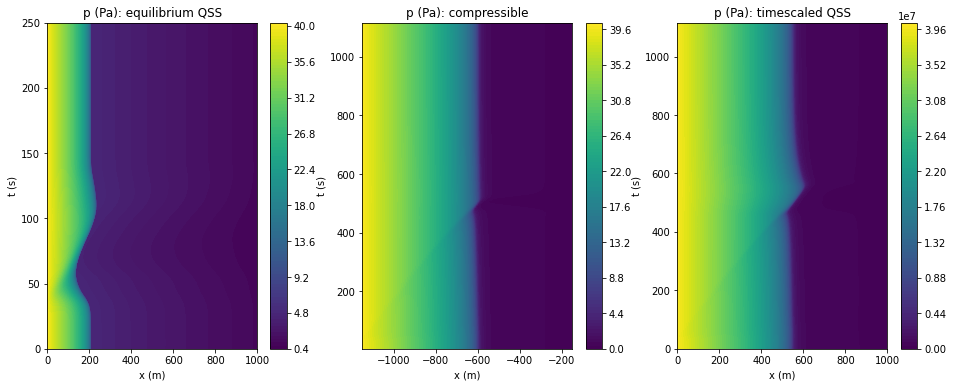

In [11]:
i = 0
plt.figure(figsize=(16, 6))
plt.subplot(1,3,1)
plt.contourf(out_xvf["mg_x"], out_xvf["mg_t"], out_xvf["q_pu"][:,0,:]/1e6, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("p (Pa): equilibrium QSS")
plt.colorbar()
plt.subplot(1,3,2)
plt.contourf(compressible_mg_x, compressible_mg_t, compressible_mg_p/1e6, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("p (Pa): compressible")
plt.colorbar()

plt.subplot(1,3,3)
plt.contourf(out_xvf_tau14["mg_x"], out_xvf_tau14["mg_t"], out_xvf_tau14["q2"][:,0,:]/1e0, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.ylim(top=compressible_mg_t.max())
plt.title("p (Pa): timescaled QSS")
plt.colorbar()

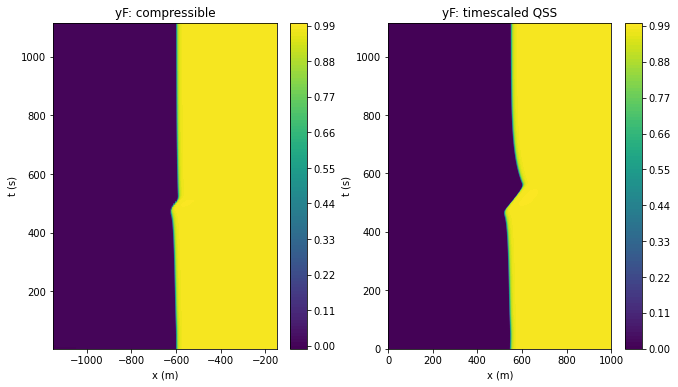

In [12]:
plt.figure(figsize=(11,6))

plt.subplot(1,2,1)
plt.contourf(compressible_mg_x, compressible_mg_t, compressible_mg_yF, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("yF: compressible")
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(out_xvf_tau14["mg_x"], out_xvf_tau14["mg_t"], out_xvf_tau14["q5"][:,-1,:]/1e0, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.ylim(top=compressible_mg_t.max())
plt.title("yF: timescaled QSS")
plt.colorbar()

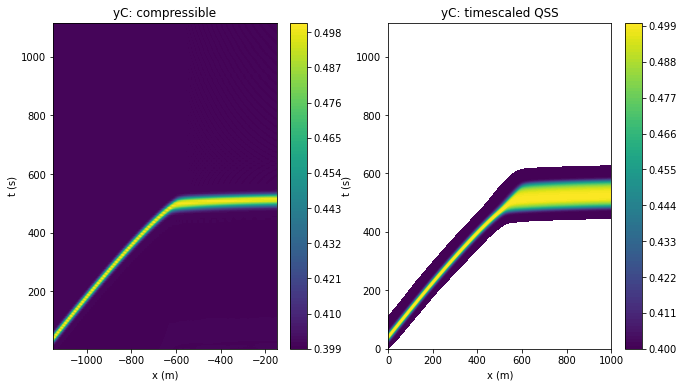

In [15]:
plt.figure(figsize=(11,6))

plt.subplot(1,2,1)
plt.contourf(compressible_mg_x, compressible_mg_t, compressible_mg_yC, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("yC: compressible")
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(out_xvf_tau14["mg_x"], out_xvf_tau14["mg_t"], out_xvf_tau14["q5"][:,3,:]/1e0, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.ylim(top=compressible_mg_t.max())
plt.title("yC: timescaled QSS")
plt.colorbar()

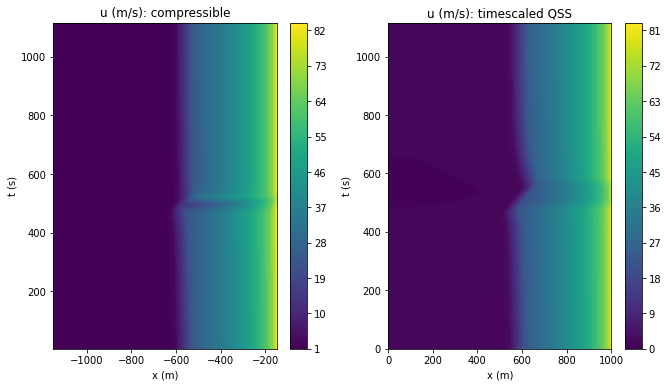

In [14]:
plt.figure(figsize=(11,6))

plt.subplot(1,2,1)
plt.contourf(compressible_mg_x, compressible_mg_t, compressible_mg_u, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("u (m/s): compressible")
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(out_xvf_tau14["mg_x"], out_xvf_tau14["mg_t"], out_xvf_tau14["q2"][:,1,:]/1e0, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.ylim(top=compressible_mg_t.max())
plt.title("u (m/s): timescaled QSS")
plt.colorbar()

In [16]:
# Fill in density for QSS solver result
rhoM = 2.6e3 * (1 + ((out_xvf_tau14["q2"][:,0,:]- 36e6) / 10e9))
# solvers[0].physics.Gas[1]["R"] == 461.3762486126526
rhoWv = out_xvf_tau14["q2"][:,0,:] / (1050 * solvers[0].physics.Gas[1]["R"])

yWv = out_xvf_tau14["q5"][:,1,:]
out_xvf_tau14["rho"] = 1.0 / (yWv / rhoWv + (1 - yWv) / rhoM)

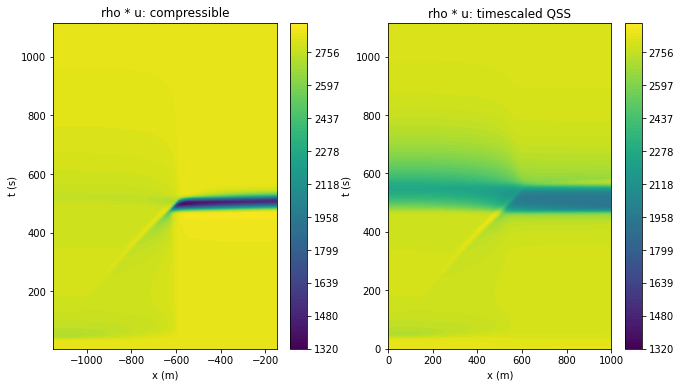

In [17]:
plt.figure(figsize=(11,6))

plt.subplot(1,2,1)
plt.contourf(compressible_mg_x, compressible_mg_t, compressible_mg_rho * compressible_mg_u, levels=np.linspace(1320,2900,100))
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("rho * u: compressible")
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(out_xvf_tau14["mg_x"], out_xvf_tau14["mg_t"], out_xvf_tau14["rho"] * out_xvf_tau14["q2"][:,1,:], levels=np.linspace(1320,2900,100))
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.ylim(top=compressible_mg_t.max())
plt.title("rho * u: timescaled QSS")
plt.colorbar()

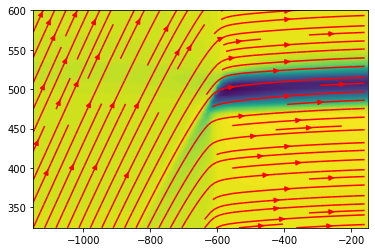

In [18]:
plt.contourf(compressible_mg_x, compressible_mg_t, compressible_mg_rho * compressible_mg_u, levels=np.linspace(1320,2900,100))
plt.ylim(324, 600)
plt.streamplot(compressible_mg_x[40:80,::99],
           compressible_mg_t[40:80,::99],
           compressible_mg_u[40:80,::99],
           np.ones_like(compressible_mg_u)[40:80,::99], color='r')
# plt.ylim()

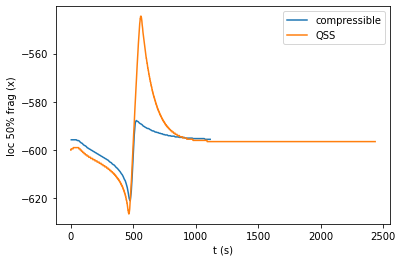

In [19]:
front_idx = np.argmax(compressible_mg_yF > 0.5, axis=1)
compressible_mg_xF = compressible_mg_x[np.ones_like(front_idx), front_idx]

front_idx = np.argmax(out_xvf_tau14["q5"][:,-1,:] > 0.5, axis=1)
qss_xF = out_xvf_tau14["x"][front_idx]

plt.plot(compressible_mg_t[:,0], compressible_mg_xF)
plt.plot(out_xvf_tau14["t"], qss_xF - 1150)

plt.xlabel("t (s)")
plt.ylabel("loc 50% frag (x)")
plt.legend(["compressible", "QSS"])


#### Other stuff

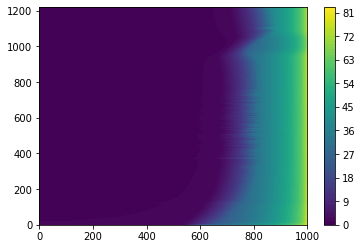

In [218]:
# plt.contourf(out_xvf_tau7["mg_x"], out_xvf_tau7["mg_t"], out_xvf_tau7["q5"][:,-1,:]/1e0, levels=100)
plt.contourf(out_xvf_tau7["mg_x"], out_xvf_tau7["mg_t"], out_xvf_tau7["q2"][:,1,:]/1e0, levels=100)
plt.colorbar()

Text(0, 0.5, 'u0 (m/s)')

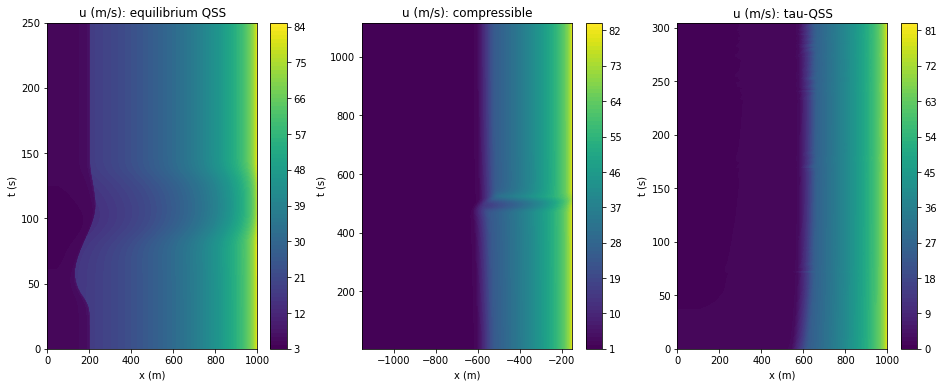

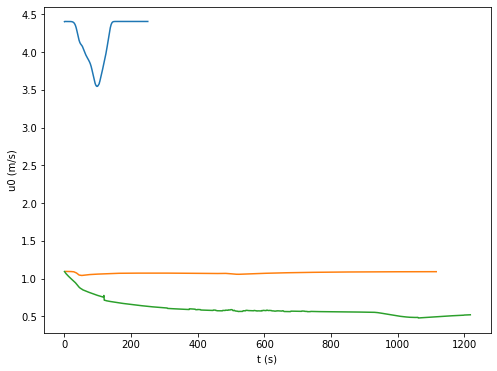

In [219]:
i = 0
plt.figure(figsize=(16, 6))
plt.subplot(1,3,1)
plt.contourf(out_xvf["mg_x"], out_xvf["mg_t"], out_xvf["q_pu"][:,1,:], levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("u (m/s): equilibrium QSS")
plt.colorbar()
plt.subplot(1,3,2)
plt.contourf(compressible_mg_x, compressible_mg_t, compressible_mg_u, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("u (m/s): compressible")
plt.colorbar()

plt.subplot(1,3,3)
plt.contourf(out_xvf_tau4["mg_x"], out_xvf_tau4["mg_t"], out_xvf_tau4["q2"][:,1,:]/1e0, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("u (m/s): tau-QSS")
plt.colorbar()

plt.figure(figsize=(8, 6))
plt.plot(out_xvf["t"], out_xvf["q_pu"][:,1,0])
plt.plot(compressible_mg_t[:,0], compressible_mg_u[:,0])
plt.plot(out_xvf_tau7["t"], out_xvf_tau7["q2"][:,1,0])

plt.xlabel("t (s)")
plt.ylabel("u0 (m/s)")

Text(0.5, 1.0, 'Estimated drag coefficient, compressible')

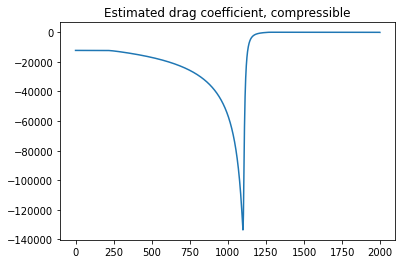

In [192]:
# Estimate dp/dx
p_nonhydro = (p_t)[0,...][:,1,0]
dpdx_nonhydro = np.diff(p_nonhydro) / (x_nodes[1,1,0] - x_nodes[0,1,0])
dpdx_nonhydro += 9.8 * 0.5 * (rho_t[0,1:,1,0] + rho_t[0,:-1,1,0])
u_est = 0.5 * (u_t[0,1:,1,0] + u_t[0,:-1,1,0])
plt.plot(dpdx_nonhydro / u_est)
plt.title("Estimated drag coefficient, compressible")

In [152]:
R_wv= 487
T = 1050
rhoM = 2600 * (1 + (out_xvf_tau4["q2"][0,0,:] - 36000000.0)/10e9)

In [155]:
out_xvf_tau4["q5"].shape

(1001, 5, 2001)

In [158]:
out_xvf_tau4["rho"] = \
  1.0 / (out_xvf_tau4["q5"][:,1,:] * R_wv * T / out_xvf_tau4["q2"][:,0,:] + (1.0 - out_xvf_tau4["q5"][:,1,:]) / rhoM)

In [157]:
out_xvf_tau4["rho"]

array([2600.9803158024906  , 2600.97608785737    , 2600.9718599232924  ,
       ...,   18.090816825152636,   17.873814679581045,
         17.494265993498352])

In [196]:
out_xvf_tau4["rho"].shape

(1001, 2001)

Text(0.5, 1.0, 'Estimated drag coefficient, compressible')

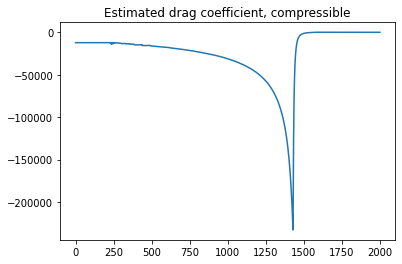

In [197]:
# Estimate dp/dx
p_nonhydro_query = (out_xvf_tau4["q2"][0,0,:])
dpdx_nonhydro_query = np.diff(p_nonhydro_query) / (out_xvf_tau4["x"][1] - out_xvf_tau4["x"][0])
dpdx_nonhydro_query += 9.8*0.5*(out_xvf_tau4["rho"][0,1:] + out_xvf_tau4["rho"][0,:-1])
u_est_query = 0.5 * (out_xvf_tau4["q2"][0,1,1:] + out_xvf_tau4["q2"][0,1,:-1])
plt.plot(dpdx_nonhydro_query / u_est_query)
plt.title("Estimated drag coefficient, compressible")

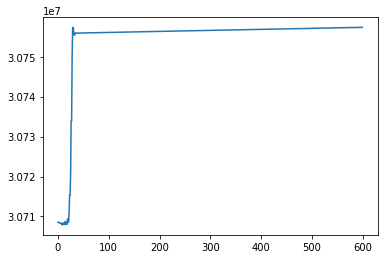

In [181]:
_physics = solvers[0].physics
ref_drag = _physics.source_terms[1].compute_viscosity(solver1D_from(1)[0].state_coeffs, _physics)
ref_drag.shape
plt.plot(ref_drag.ravel() * (8 / 50*50))

Text(0.5, 1.0, 'Estimated drag coefficient (neglecting u^2), compressible, QSS')

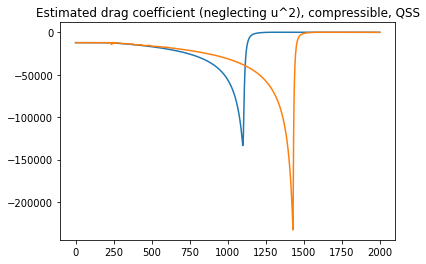

In [198]:
plt.plot(dpdx_nonhydro / u_est)
plt.plot(dpdx_nonhydro_query / u_est_query)
plt.title("Estimated drag coefficient (neglecting u^2), compressible, QSS")

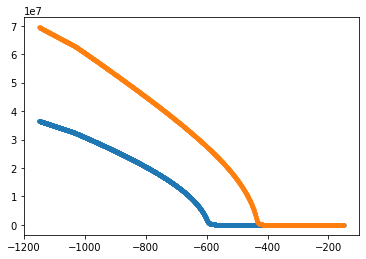

In [118]:
plt.plot(x_nodes.ravel(), p_t[0,...].ravel() / u_t[0,...].ravel(), '.')
plt.plot(out_xvf_tau4["x"] - 1150, out_xvf_tau4["q2"][0,0,:] / out_xvf_tau4["q2"][0,1,:], '.')


In [95]:
# plt.contourf(out_xvf_tau4["mg_x"], out_xvf_tau4["mg_t"], out_xvf_tau4["q2"][:,0,:]/1e0, levels=100)
0.03 * (1.0 - 0.4) / (1.0 + 0.03), yWt_compressible
# plt.colorbar()

(0.017475728155339803,
 array([[[0.017443384887059],
         [0.017440354718785],
         [0.017437120200234]],
 
        [[0.017437120216097],
         [0.017433578272538],
         [0.017429803374064]],
 
        [[0.01742980339199 ],
         [0.017425679593199],
         [0.01742129151032 ]],
 
        ...,
 
        [[0.017490946951861],
         [0.017490979877817],
         [0.01749101595537 ]],
 
        [[0.017491015992964],
         [0.017491058179251],
         [0.017491107264825]],
 
        [[0.017491107613997],
         [0.017491180404924],
         [0.017491310417934]]]))

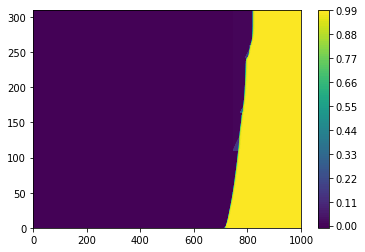

In [70]:
plt.contourf(out_xvf_tau4["mg_x"], out_xvf_tau4["mg_t"], out_xvf_tau4["q5"][:,4,:]/1e0, levels=100)
plt.colorbar()

In [63]:
split_solver

NameError: name 'split_solver' is not defined

In [48]:
out_xvf_tau["mg_t"][[0,1],0]

array([0.               , 0.003096602321315])

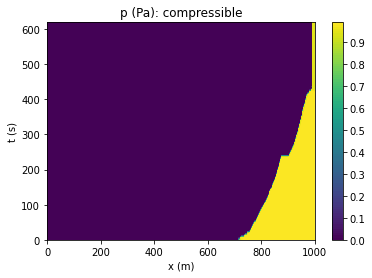

In [52]:
plt.contourf(out_xvf_tau["mg_x"], out_xvf_tau["mg_t"], out_xvf_tau["q5"][:,4,:]/1e0, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("p (Pa): compressible")
plt.colorbar()

#### Animations

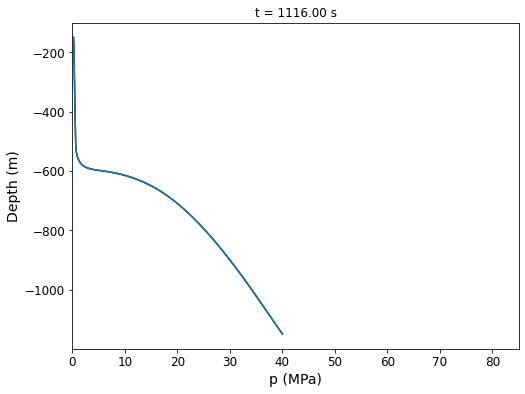

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

FFMpegWriter = matplotlib.animation.writers['ffmpeg']
writer = FFMpegWriter(fps=15)

fig = plt.figure(figsize=(8,6))
bg_curve, = plt.plot(p_t[0,:].ravel()/1e6, x_nodes.ravel(), 'k-', markersize = 10)
data_curve, = plt.plot(p_t[0,:].ravel()/1e6, x_nodes.ravel(), '-', markersize = 10)
plt.xlabel('p (MPa)', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=12)
plt.xlim(0, 85)

with writer.saving(fig, "p_quail_test.mp4", dpi=100):
  for i in range(0, p_t.shape[0], 1):
    data_curve.set_data(p_t[i,:].ravel()/1e6, x_nodes.ravel())
    plt.title(f"t = {t_range[i]:.2f} s")
    writer.grab_frame()

In [59]:
solvers[0].stepper.dt

7.407407407407407e-05

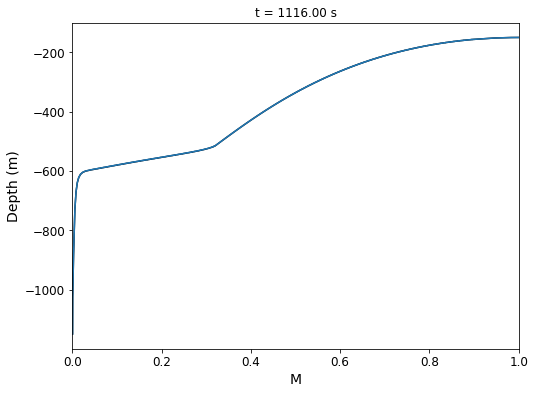

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

FFMpegWriter = matplotlib.animation.writers['ffmpeg']
writer = FFMpegWriter(fps=15)

fig = plt.figure(figsize=(8,6))
bg_curve, = plt.plot(M_t[0,:].ravel(), x_nodes.ravel(), 'k-', markersize = 10)
data_curve, = plt.plot(M_t[0,:].ravel(), x_nodes.ravel(), '-', markersize = 10)
plt.xlabel('M', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=12)
plt.xlim(0, 1)

with writer.saving(fig, "M_quail_test.mp4", dpi=100):
  for i in range(0, M_t.shape[0], 1):
    data_curve.set_data(M_t[i,:].ravel(), x_nodes.ravel())
    plt.title(f"t = {t_range[i]:.2f} s")
    writer.grab_frame()

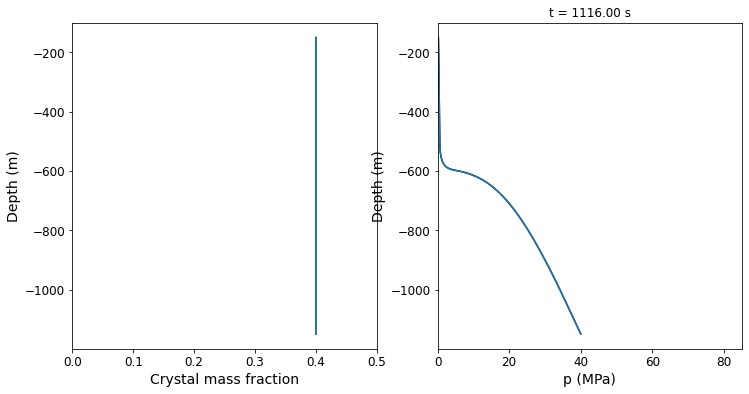

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

FFMpegWriter = matplotlib.animation.writers['ffmpeg']
writer = FFMpegWriter(fps=15)

fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
bg_curve1, = plt.plot(yC_t[0,:].ravel(), x_nodes.ravel(), 'k-', markersize = 10)
data_curve1, = plt.plot(yC_t[0,:].ravel(), x_nodes.ravel(), '-', markersize = 10)
plt.xlabel('Crystal mass fraction', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=12)
plt.xlim(0, 0.5)

plt.subplot(1,2,2)
bg_curve2, = plt.plot(p_t[0,:].ravel()/1e6, x_nodes.ravel(), 'k-', markersize = 10)
data_curve2, = plt.plot(p_t[0,:].ravel()/1e6, x_nodes.ravel(), '-', markersize = 10)
plt.xlabel('p (MPa)', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=12)
plt.xlim(0, 85)


with writer.saving(fig, "yC_quail_test.mp4", dpi=100):
  for i in range(0, yC_t.shape[0], 1):
    data_curve1.set_data(yC_t[i,:].ravel(), x_nodes.ravel())
    data_curve2.set_data(p_t[i,:].ravel()/1e6, x_nodes.ravel())
    plt.title(f"t = {t_range[i]:.2f} s")
    writer.grab_frame()

In [6]:
p0 = mdtools.downsample(solver1D_from(0), "Pressure")[1]

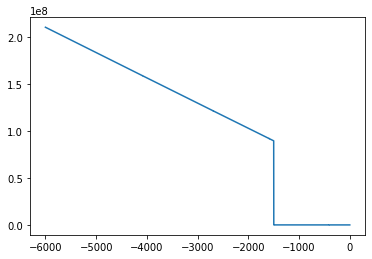

In [9]:
x, u = mdtools.downsample(solver, "XVelocity")
_, c = mdtools.downsample(solver, "SoundSpeed")
_, p = mdtools.downsample(solver, "Pressure")
_, phi = mdtools.downsample(solver, "phi")
_, T = mdtools.downsample(solver, "Temperature")
_, Gamma = mdtools.downsample(solver, "Gamma")
plt.plot(x.ravel(), p0.ravel())

In [10]:
solver.state_coeffs[...,-3]

array([[8.356278515800366e+01, 8.142000877338839e+01],
       [8.140363166639605e+01, 7.986561961463916e+01],
       [7.986019465247801e+01, 7.916395881661217e+01],
       ...,
       [5.758174678064405e-03, 5.756801587063025e-03],
       [5.756801368449446e-03, 5.755776233927476e-03],
       [5.755775436353539e-03, 5.753254378038122e-03]])

In [11]:
# Secondary computations
rho    = solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
arhoWt = solver.state_coeffs[...,-3:-2]
yWt = arhoWt / rho
yWv = solver.state_coeffs[...,1:2] / rho
yM  = solver.state_coeffs[...,2:3] / rho
sRatio = T ** Gamma / p ** (Gamma-1)
# Soluble concentration
xd = solver.physics.Solubility["k"] * p ** solver.physics.Solubility["n"]

In [12]:
solver.physics.source_terms[1].crit_volfrac

0.8

Text(0, 0.5, 'sRatio')

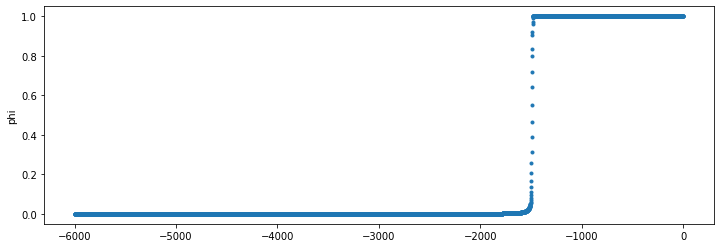

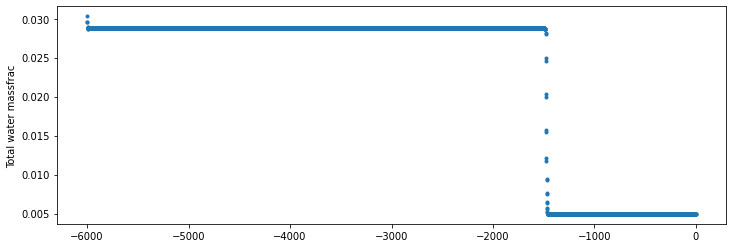

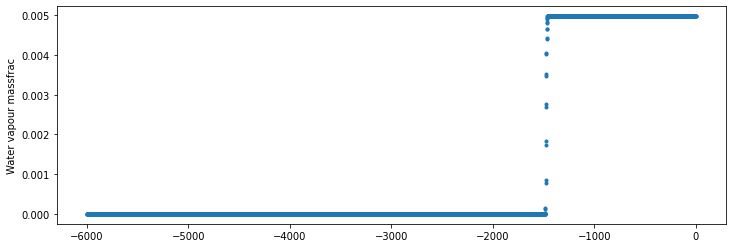

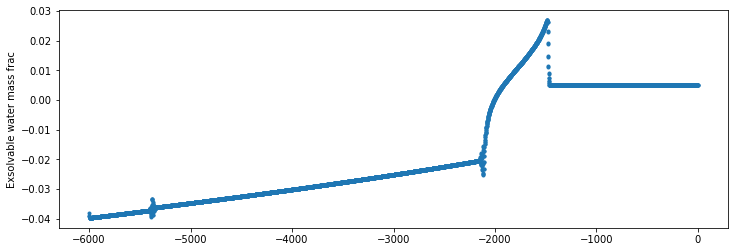

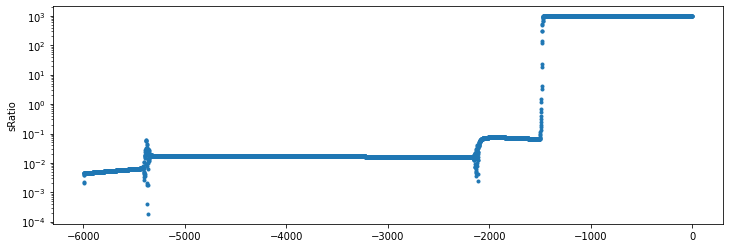

In [13]:
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), phi.ravel(), '.'); plt.ylabel("phi")
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), yWt.ravel(), '.'); plt.ylabel("Total water massfrac")
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), yWv.ravel(), '.'); plt.ylabel("Water vapour massfrac")
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), (yWt-(xd/(1+xd))*yM).ravel(), '.'); plt.ylabel("Exsolvable water mass frac")
plt.figure(figsize=(12,4))
plt.semilogy(x.ravel(), np.abs(sRatio-sRatio[0,0,0]).ravel(), '.'); plt.ylabel("sRatio")

(1500.0, 2014.7297259269903)

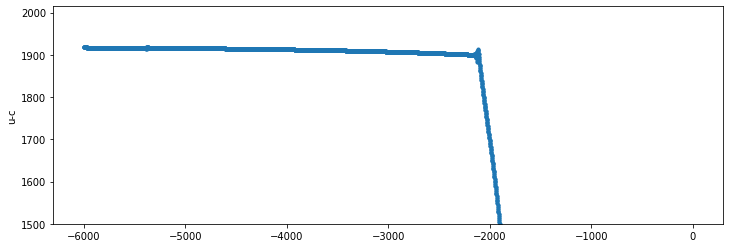

In [14]:
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), np.abs(u-c).ravel(), '.'); plt.ylabel("u-c")
plt.ylim(bottom=1.5e3)

Text(0, 0.5, 'p')

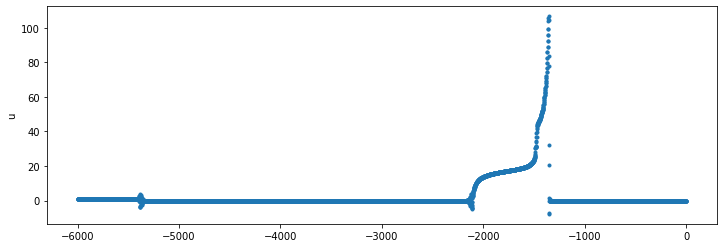

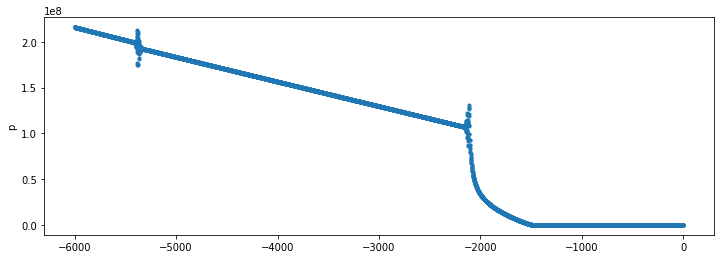

In [15]:
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), u.ravel(), '.'); plt.ylabel("u")
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), p.ravel(), '.'); plt.ylabel("p")

(999.0, 1001.0)

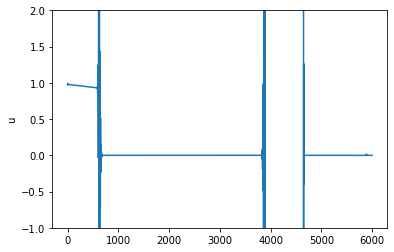

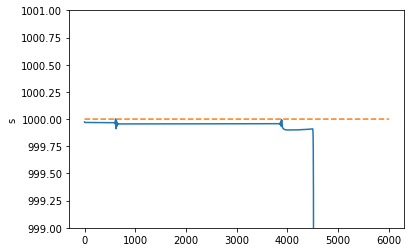

In [39]:
plt.plot(u.ravel())
plt.ylim(-1,2)
plt.ylabel("u")
plt.figure()
plt.plot(sRatio.ravel())
plt.ylabel("s")
rhoChamber = solver.physics.BCs["x1"].trace_arho*2 + 2.7e3
yWvChamber = solver.physics.BCs["x1"].trace_arho / rhoChamber
cpChamber = yWvChamber * solver.physics.Gas[1]["c_p"] + (1 - yWvChamber) * solver.physics.Liquid["c_m"]
cvChamber = yWvChamber * solver.physics.Gas[1]["c_v"] + (1 - yWvChamber) * solver.physics.Liquid["c_m"]
GammaChamber = cpChamber / cvChamber
s_target = solver.physics.BCs["x1"].T_chamber**GammaChamber / solver.physics.BCs["x1"].p_chamber**(GammaChamber-1)
plt.plot(s_target*np.ones_like(sRatio.ravel()), '--')
plt.ylim((999,1001))

In [253]:
drag = solver.physics.source_terms[1].get_source(solver.physics, solver.state_coeffs, 00, 00)[:,:,3]

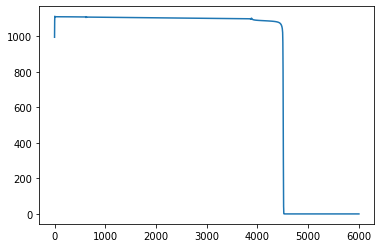

In [40]:
plt.plot(solver.state_coeffs[...,6].ravel())

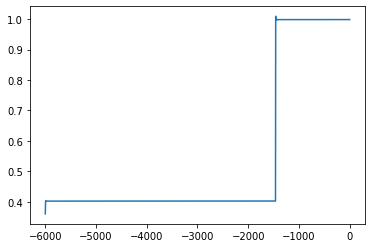

In [41]:
# plt.semilogy(x.ravel(), solver.state_coeffs[...,2].ravel(), '.-')
# plt.xlim((-3000,-500))
# plt.ylim((2.65e3, 2.8e3))
# plt.plot(x.ravel(), drag.ravel()/u.ravel())
plt.plot(x.ravel(), solver.state_coeffs[...,-2].ravel() / solver.state_coeffs[...,2].ravel())

Text(0, 0.5, 'Delta p')

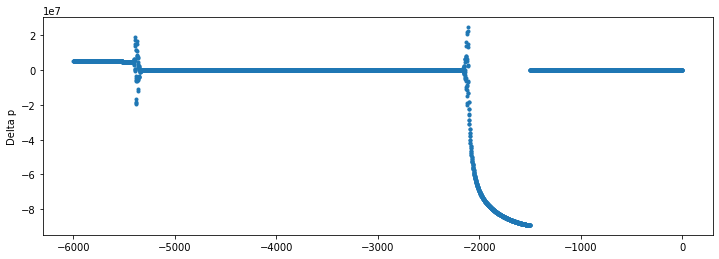

In [42]:
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), (p-p0).ravel(), '.'); plt.ylabel("Delta p")
# plt.figure(figsize=(12,4))
# plt.plot(x.ravel(), p.ravel(), '.'); plt.ylabel("u")

In [43]:
#  'compute_indicator',
#  'compute_viscosity',
#  'conduit_radius',
#  'crit_volfrac',
#  'get_indicator_deriv',
#  'get_jacobian',
#  'get_phi_gradient',
#  'get_source',
#  'logistic_scale',
#  'source_treatment']

friction_term = solver.physics.source_terms[1]
# plt.semilogy(friction_term.compute_indicator(phi).ravel())
# plt.plot(friction_term.compute_viscosity(solver.state_coeffs, solver.physics).ravel())
# plt.plot(, '-')
# F = friction_term.get_source(solver.physics, solver.state_coeffs, 000, 000).ravel()
# x = np.array([solver.mesh.node_coords[0:-1,0], solver.mesh.node_coords[1:,0]]
# F.shape

In [44]:
''' Simulate .get_source '''
Uq = solver.state_coeffs
physics = solver.physics

if physics.NDIMS != 1:
  raise Exception(f"Conduit friction source not suitable for use in " +
                  f"{physics.NDIMS} spatial dimensions.")
iarhoA, iarhoWv, iarhoM, imom, ie, iarhoWt, iarhoC, iarhoFm = \
  physics.get_state_indices()

''' Compute mixture density, u, friction coefficient '''
rho = np.sum(Uq[:, :, physics.get_mass_slice()],axis=2,keepdims=True)
u = Uq[:, :, physics.get_momentum_slice()] / (rho + 1e-15)
mu = friction_term.compute_viscosity(Uq, physics)
fric_coeff = 8.0 * mu / friction_term.conduit_radius**2.0
''' Compute indicator based on magma porosity '''
#I = self.compute_indicator( \
#	physics.compute_additional_variable("phi", Uq, True))
''' Compute source vector at each element [ne, nq] '''
S = np.zeros_like(Uq)
S[:, :, physics.get_momentum_slice()] = -fric_coeff * u
S[:, :, physics.get_state_slice("Energy")] = -fric_coeff * u**2.0

mu = friction_term.compute_viscosity(solver.state_coeffs, solver.physics)

C:\Users\Fredric\Documents\Volcano\quail_volcano\src\physics\multiphasevpT\functions.py:2427: RuntimeWarning: invalid value encountered in log
  log_mfWd = np.log(mfWd*100)


5e-05

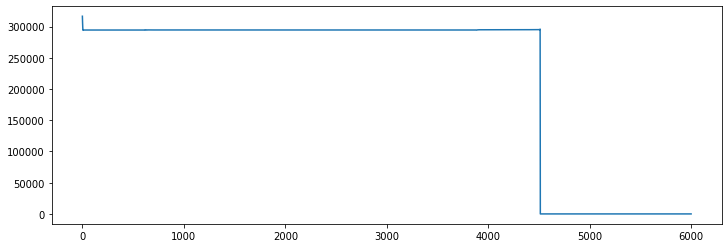

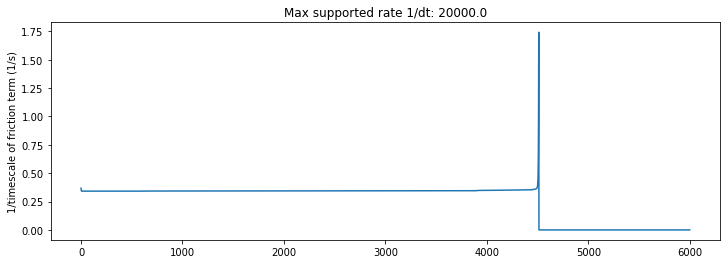

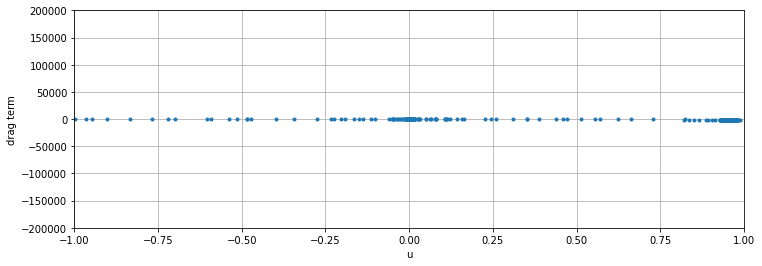

In [45]:
# plt.figure(figsize=(12,4))
# plt.plot(S[:,:,3].ravel())
plt.figure(figsize=(12,4))
plt.plot(mu.ravel())

coeff = 8.0 * mu / friction_term.conduit_radius**2.0
# Plot friction coefficient
# plt.figure(figsize=(12,4))
# plt.plot(coeff.ravel())
# Plot source lambda
plt.figure(figsize=(12,4))
ll = coeff / rho
plt.plot(ll.ravel())
plt.ylabel("1/timescale of friction term (1/s)")
plt.title(f"Max supported rate 1/dt: {1/solver.stepper.dt}")

# Friction reaction plot
plt.figure(figsize=(12,4))
plt.plot(u.ravel(), S[:,:,3].ravel(), '.')
plt.xlim((-1,1))
plt.ylim((-2e5,2e5))
plt.xlabel("u")
plt.ylabel("drag term")
plt.grid("both")

array([3.])

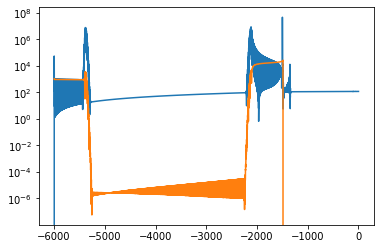

In [46]:
# d(Delta p)/dx removing hydrostatic
# plt.plot(x.ravel(), (p - p0).ravel())

semilogyabs = lambda dat: plt.semilogy(x.ravel(), np.abs(dat).ravel())


# Approximate dp/dx
dx = solver.mesh.node_coords[1] - solver.mesh.node_coords[0]
pdx_approx =  np.diff((p - p0).ravel(), prepend=(p-p0)[0,0]) / dx

# Compute gravity source
Sgrav = solver.physics.source_terms[0].get_source(solver.physics, solver.state_coeffs, 000, 000)

semilogyabs(pdx_approx)
semilogyabs(S[...,3])
# semilogyabs(Sgrav[...,3])

In [200]:
Sgrav[:,:,3].ravel()

array([-26910.31117181584 , -26910.06048930237 , -26910.060463256596, ...,
       -17184.358235029173, -16390.74406601727 , -13623.128676371585])

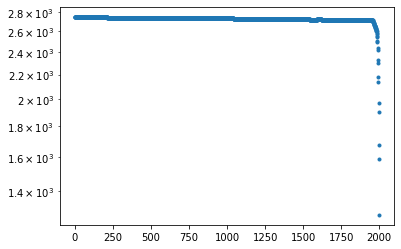

In [170]:
%matplotlib inline
plt.semilogy(solver.state_coeffs[:,:,2].ravel(), '.')

In [158]:
solver.params["ArtificialViscosity"], solver.params["AVParameter"]

(True, 500)

In [5]:
get_var = lambda name: solver.physics.compute_variable(name, solver.state_coeffs)
plt.plot(get_var("Pressure"))

TypeError: <lambda>() missing 1 required positional argument: 'name'